# Time Series Analysis
# Hourly Energy Consumption

# Rajas Vaidya (MDS202131)
# Rishika Tibrewal (MDS202135)

# Importing Libraries

In [ ]:
# ! pip install pystan==2.19.1.1 && ! pip install fbprophet

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from datetime import datetime
from fbprophet import Prophet
import matplotlib.pyplot as plt


from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Loading Dataset

In [ ]:
!unzip /content/drive/MyDrive/PJME_hourly.csv.zip

Archive:  /content/drive/MyDrive/PJME_hourly.csv.zip
replace PJME_hourly.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PJME_hourly.csv         


In [ ]:
data = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])
data.columns=["Energy"]
data.sort_index().head(10)

,Energy
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
2002-01-01 06:00:00,28654.0
2002-01-01 07:00:00,29308.0
2002-01-01 08:00:00,29595.0
2002-01-01 09:00:00,29943.0


# Exploratory Data Analysis

In [ ]:
data.sort_index().tail(10)

,Energy
Datetime,
2018-08-02 15:00:00,47154.0
2018-08-02 16:00:00,46989.0
2018-08-02 17:00:00,46816.0
2018-08-02 18:00:00,46760.0
2018-08-02 19:00:00,45641.0
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0


In [ ]:
data.describe()

,Energy
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [ ]:
data.isna().sum()

Energy    0
dtype: int64

The dataset has no missing values.

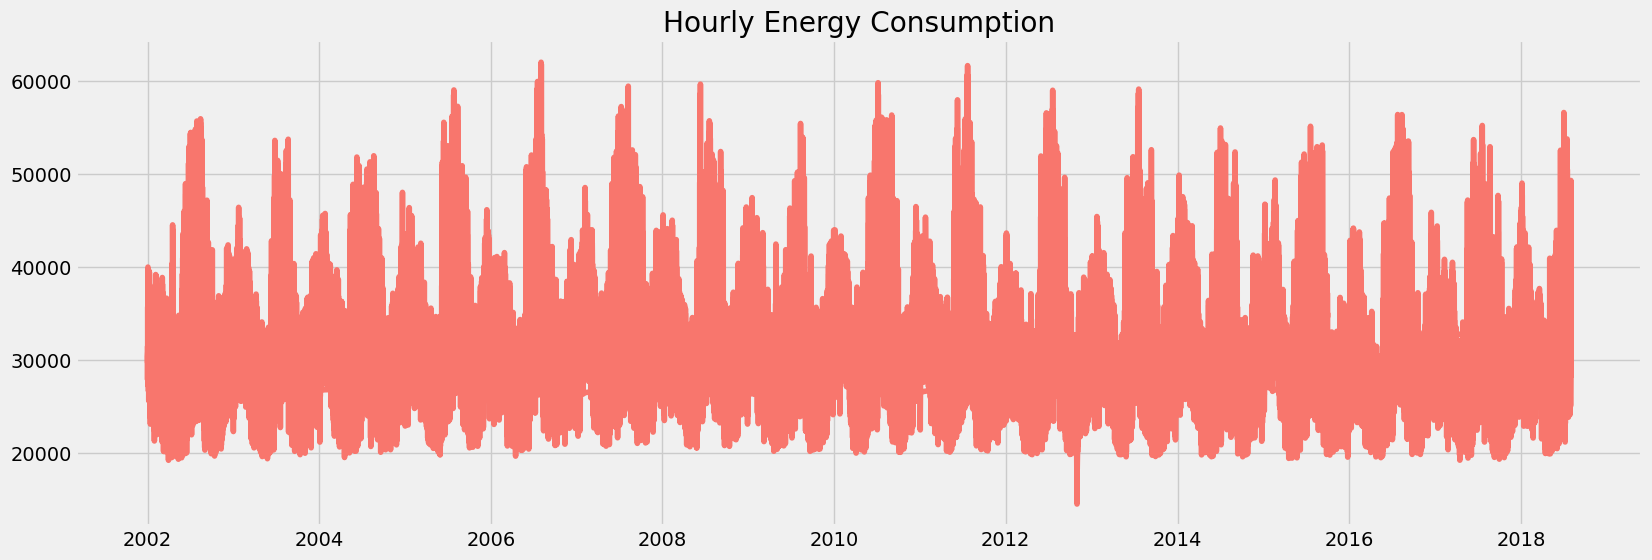

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(data,color="#F8766D")
plt.title("Hourly Energy Consumption")
plt.show()

We can see that the data has seasonality. 

# Feature Engineering

In [ ]:
# Creates time series features from datetime index
def create_features(df, label=None):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  
  X = df[['hour','dayofweek','quarter','month','year',
          'dayofyear','dayofmonth','weekofyear']]
  if label:
      y = df[label]
      return X, y
  return X

In [ ]:
X, y = create_features(data, label='Energy')
features_and_target = pd.concat([X, y], axis=1)

<ipython-input-13-0b2a7277208b>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['hour'] = df['date'].dt.hour


In [ ]:
features_and_target.sample(5)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Energy
Datetime,,,,,,,,,
2005-02-14 09:00:00,9,0,1,2,2005,45,14,7,36705.0
2017-04-06 20:00:00,20,3,2,4,2017,96,6,14,30688.0
2003-03-16 03:00:00,3,6,1,3,2003,75,16,11,23655.0
2009-11-21 12:00:00,12,5,4,11,2009,325,21,47,28972.0
2015-02-02 14:00:00,14,0,1,2,2015,33,2,6,36926.0


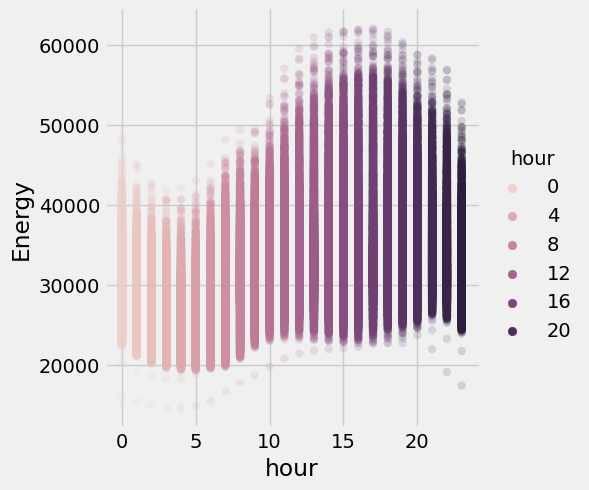

In [ ]:
sns.pairplot(features_and_target.dropna(),hue='hour',x_vars=['hour'], y_vars='Energy', height=5,plot_kws={'alpha':0.15, 'linewidth':0})
plt.show()

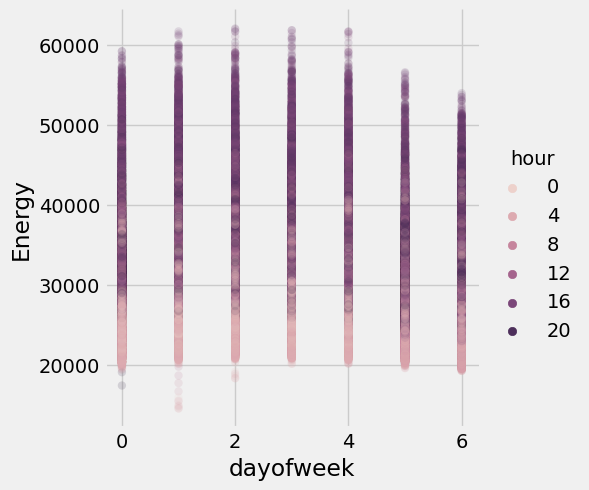

In [ ]:
sns.pairplot(features_and_target.dropna(),hue='hour',x_vars=['dayofweek'], y_vars='Energy', height=5,plot_kws={'alpha':0.15, 'linewidth':0})
plt.show()

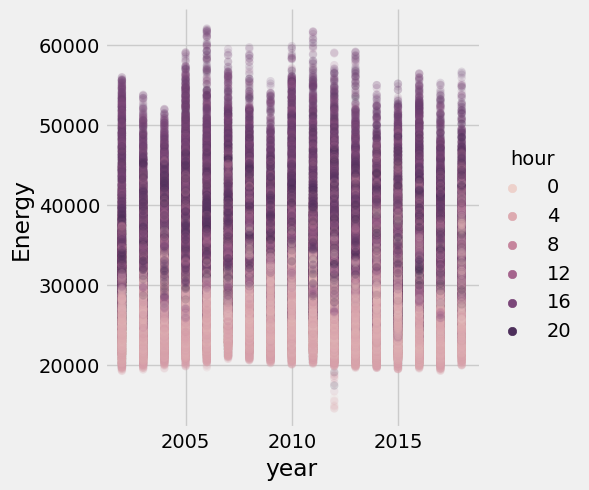

In [ ]:
sns.pairplot(features_and_target.dropna(),hue='hour',x_vars=['year'], y_vars='Energy', height=5,plot_kws={'alpha':0.15, 'linewidth':0})
plt.show()

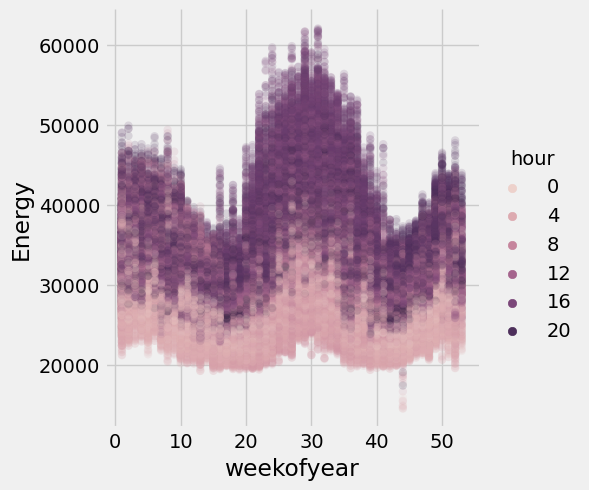

In [ ]:
sns.pairplot(features_and_target.dropna(),hue='hour',x_vars=['weekofyear'], y_vars='Energy', height=5,plot_kws={'alpha':0.15, 'linewidth':0})
plt.show()

# Stationarity

In [ ]:
print("Observations of Dickey-fuller test")
dftest = adfuller(data['Energy'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -1.882891e+01
p-value                        2.022125e-30
#lags used                     7.400000e+01
number of observations used    1.452910e+05
critical value (1%)           -3.430395e+00
critical value (5%)           -2.861560e+00
critical value (10%)          -2.566781e+00
dtype: float64


Since, the p-value is very small as compared to the level of significance 5%, we reject null hypothesis (data is non-stationary) and can conclude that the data is highly stationary.

# Classical Decomposition

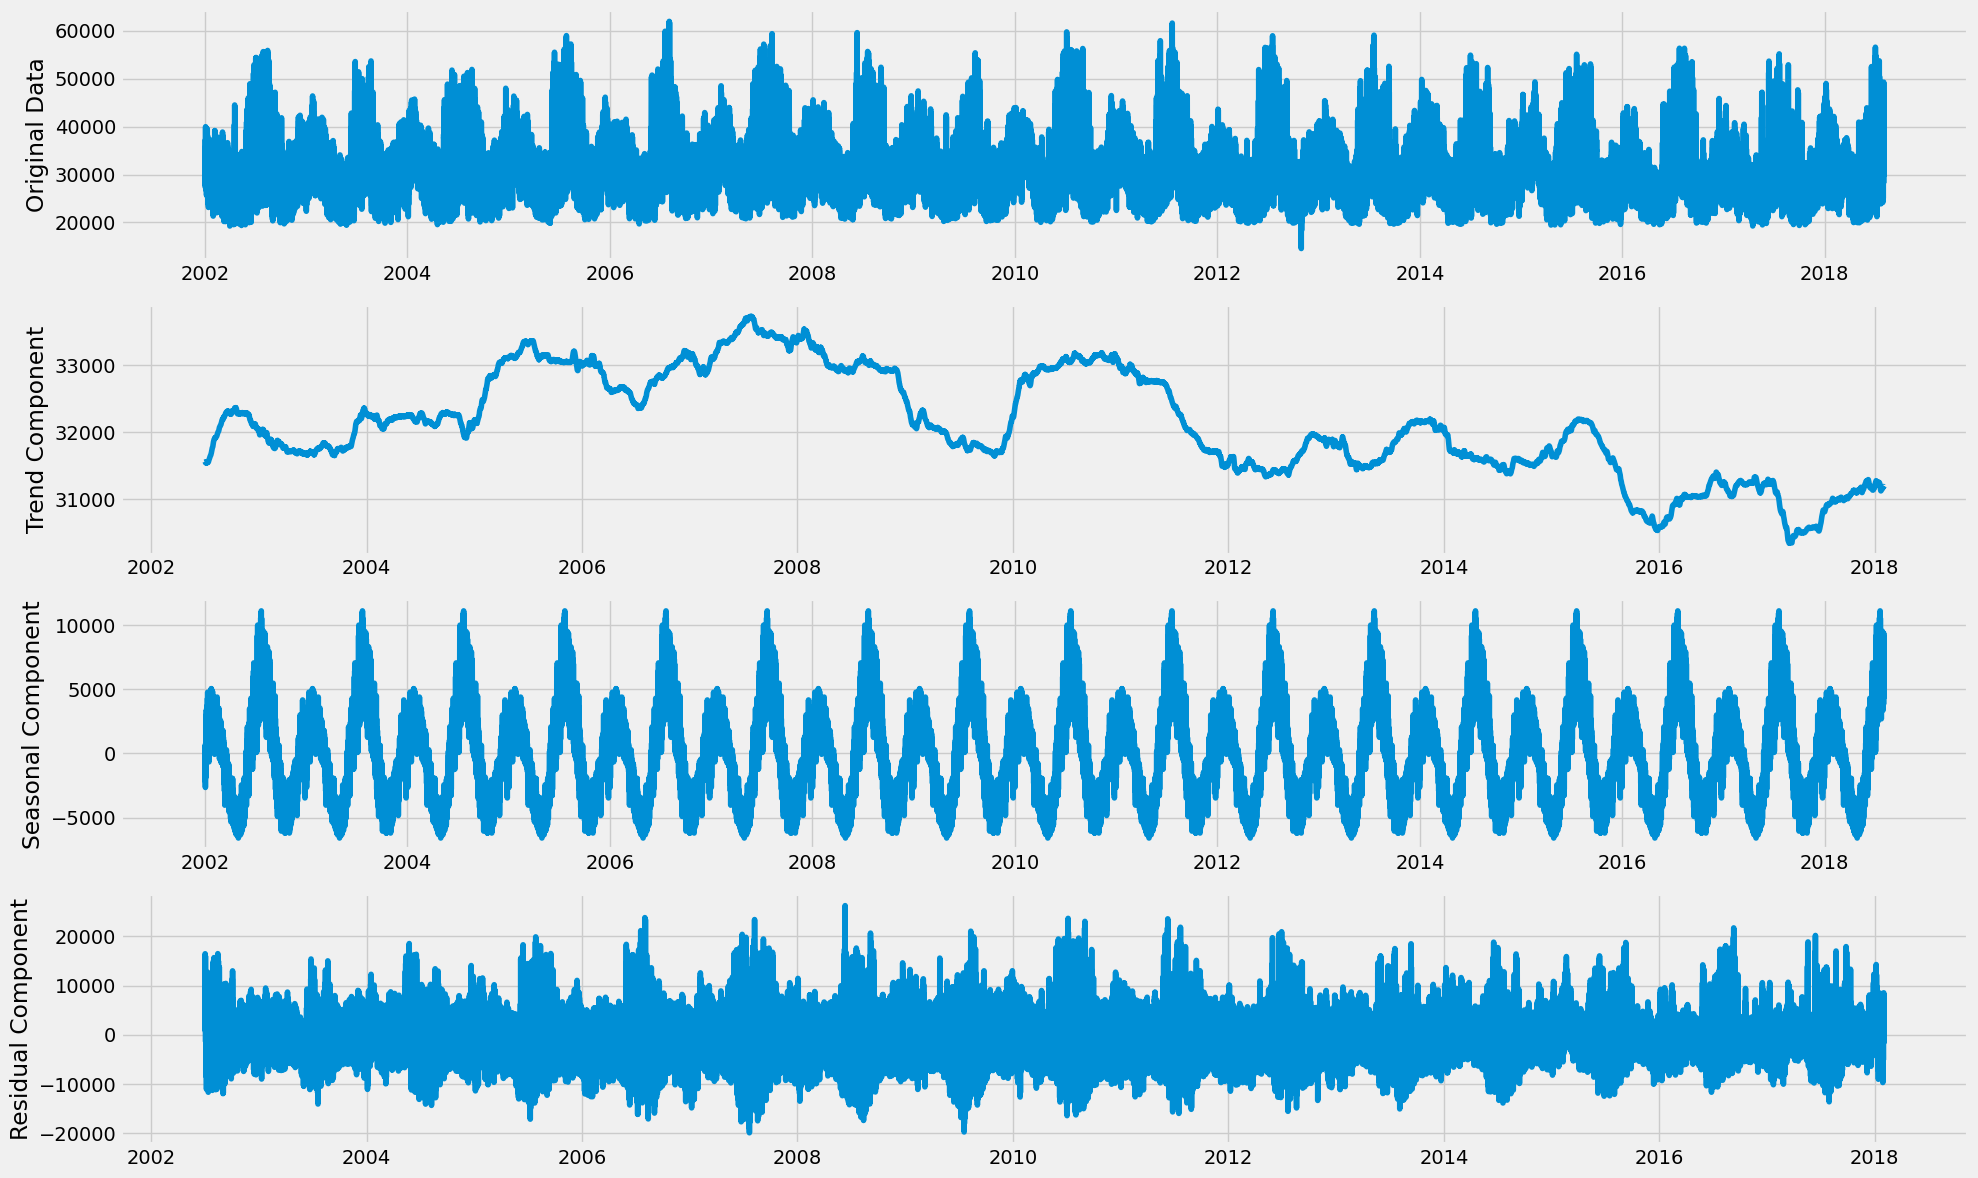

In [ ]:
# Decompose data into its components
data=data.sort_index()
result = seasonal_decompose(data["Energy"], model='additive', period=24*365)

# Plot the original data and its components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
ax1.plot(data["Energy"])
ax1.set_ylabel('Original Data')
ax2.plot(result.trend)
ax2.set_ylabel('Trend Component')
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal Component')
ax4.plot(result.resid)
ax4.set_ylabel('Residual Component')
plt.tight_layout()
plt.show()

# Train-test split

Splitting the entire dataset into training and test set. Data till 31/12/2016 is taken as training set, while thereafter is the test set.

In [ ]:
split_date = '01-Jan-2015'
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

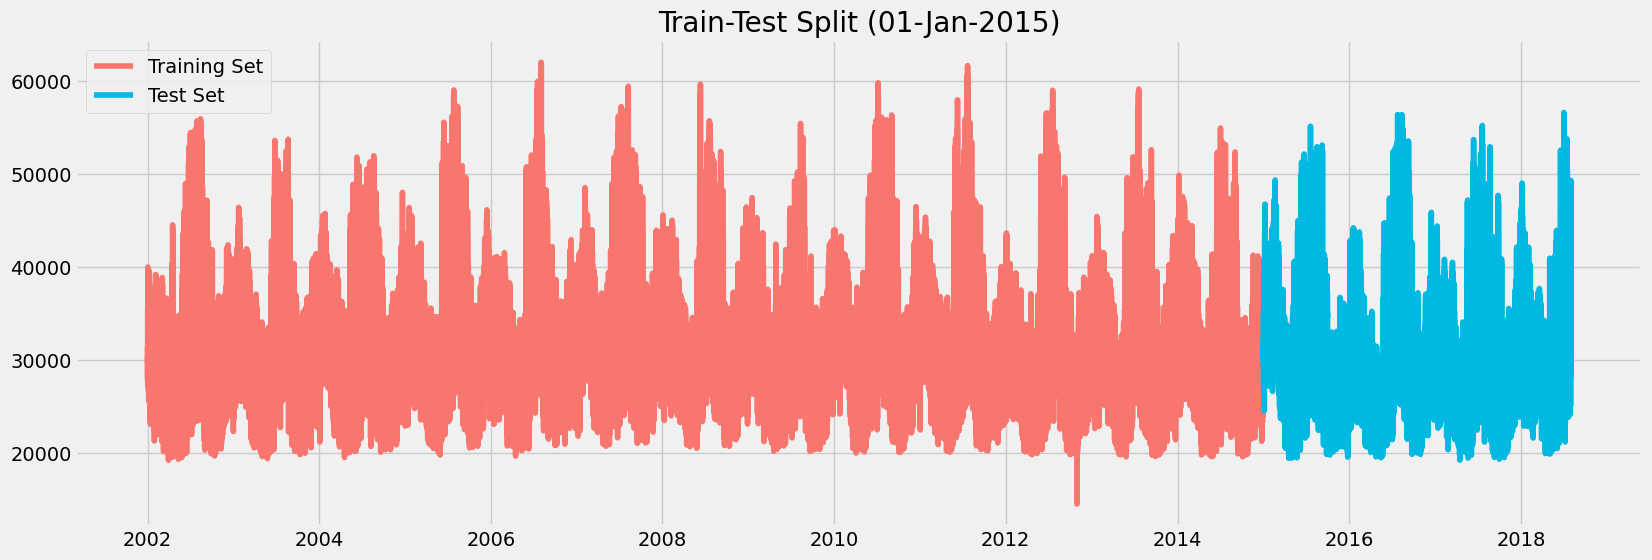

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(train["Energy"],color="#F8766D",label="Training Set")
plt.plot(test["Energy"],color="#00B9E3",label="Test Set")
plt.legend(loc="best")
plt.title("Train-Test Split (01-Jan-2015)")
plt.show()

In [ ]:
X_train, y_train = create_features(train, label='Energy')
X_test, y_test = create_features(test, label='Energy')

<ipython-input-13-0b2a7277208b>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-13-0b2a7277208b>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [ ]:
X_train.head(10)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1
2002-01-01 06:00:00,6,1,1,1,2002,1,1,1
2002-01-01 07:00:00,7,1,1,1,2002,1,1,1
2002-01-01 08:00:00,8,1,1,1,2002,1,1,1
2002-01-01 09:00:00,9,1,1,1,2002,1,1,1


In [ ]:
y_train.head()

Datetime
2002-01-01 01:00:00    30393.0
2002-01-01 02:00:00    29265.0
2002-01-01 03:00:00    28357.0
2002-01-01 04:00:00    27899.0
2002-01-01 05:00:00    28057.0
Name: Energy, dtype: float64

In [ ]:
X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-01-01 01:00:00,1,3,1,1,2015,1,1,1
2015-01-01 02:00:00,2,3,1,1,2015,1,1,1
2015-01-01 03:00:00,3,3,1,1,2015,1,1,1
2015-01-01 04:00:00,4,3,1,1,2015,1,1,1
2015-01-01 05:00:00,5,3,1,1,2015,1,1,1


In [ ]:
y_test.head()

Datetime
2015-01-01 01:00:00    31647.0
2015-01-01 02:00:00    30755.0
2015-01-01 03:00:00    30189.0
2015-01-01 04:00:00    29890.0
2015-01-01 05:00:00    30075.0
Name: Energy, dtype: float64

# ACF, PACF Plot

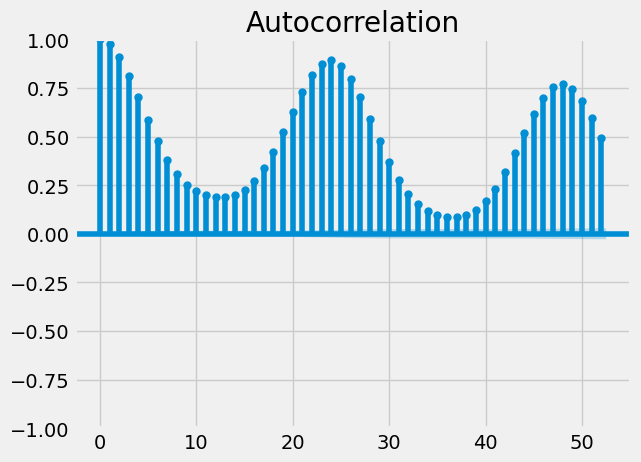

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data["Energy"])
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


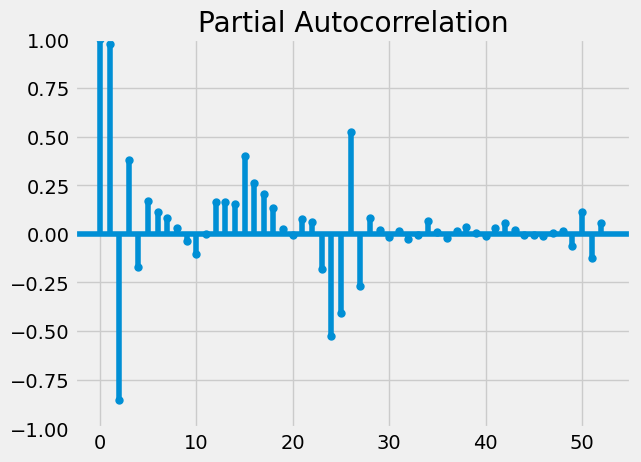

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data["Energy"])
plt.show()

# Basic Prophet Model

In [ ]:
split_date = '01-Jan-2015'
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(train.reset_index().rename(columns={'Datetime':'ds','Energy':'y'}))

In [ ]:
# Predict on training set with model
test_pred = model.predict(test.reset_index().rename(columns={'Datetime':'ds','Energy':'y'}))
test_pred.head()

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31215.101599,23851.181951,32989.917524,31215.101599,31215.101599,-2825.301981,-2825.301981,-2825.301981,-4430.423431,...,1281.444688,1281.444688,1281.444688,323.676762,323.676762,323.676762,0.0,0.0,0.0,28389.799618
1,2015-01-01 02:00:00,31215.064508,22354.004150,31619.287332,31215.064508,31215.064508,-4329.638962,-4329.638962,-4329.638962,-5927.336446,...,1272.685185,1272.685185,1272.685185,325.012299,325.012299,325.012299,0.0,0.0,0.0,26885.425546
2,2015-01-01 03:00:00,31215.027417,21555.586175,30231.772603,31215.027417,31215.027417,-5201.310745,-5201.310745,-5201.310745,-6790.420150,...,1262.720087,1262.720087,1262.720087,326.389318,326.389318,326.389318,0.0,0.0,0.0,26013.716672
3,2015-01-01 04:00:00,31214.990326,21424.116397,30190.697767,31214.990326,31214.990326,-5342.851765,-5342.851765,-5342.851765,-6922.332591,...,1251.672982,1251.672982,1251.672982,327.807844,327.807844,327.807844,0.0,0.0,0.0,25872.138561
4,2015-01-01 05:00:00,31214.953236,21868.411549,31152.601406,31214.953236,31214.953236,-4668.498494,-4668.498494,-4668.498494,-6237.446063,...,1239.679667,1239.679667,1239.679667,329.267902,329.267902,329.267902,0.0,0.0,0.0,26546.454742


/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


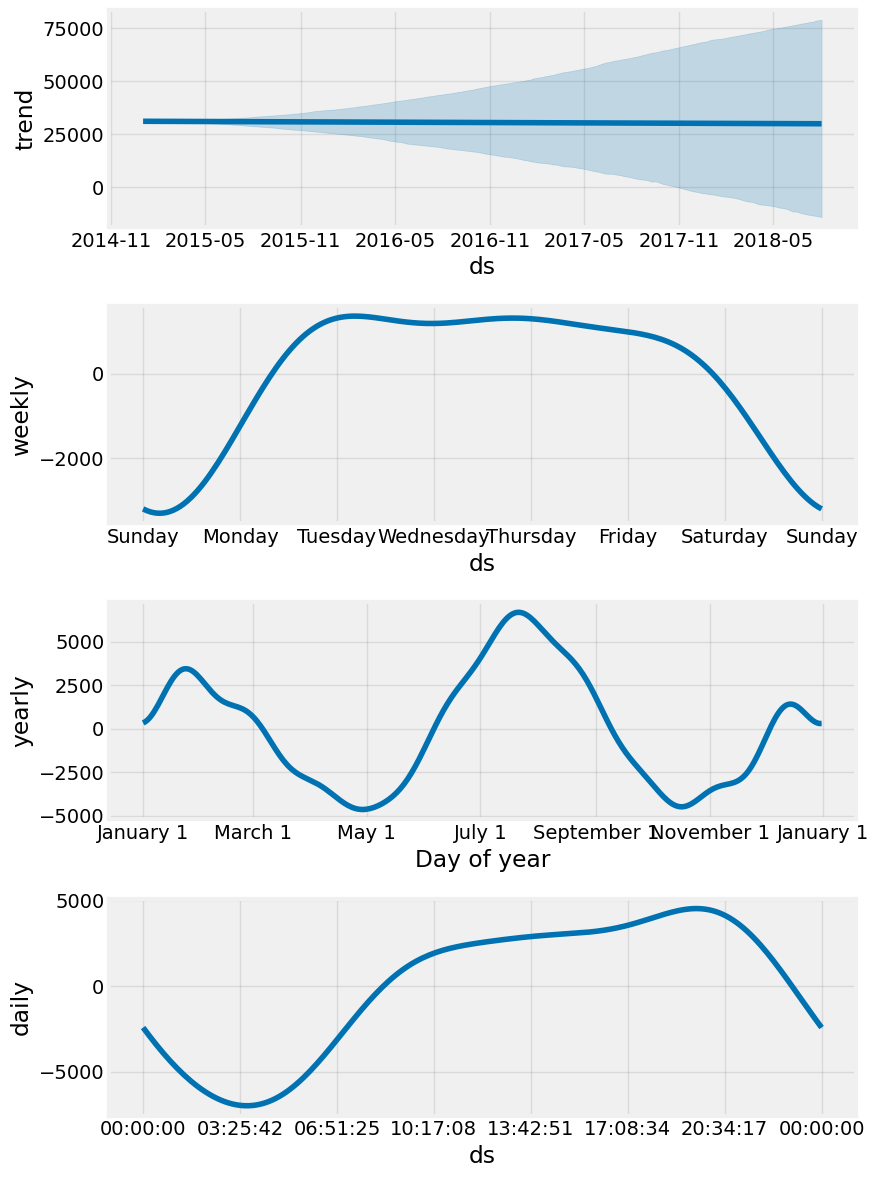

In [ ]:
# Plot the components of the model
fig = model.plot_components(test_pred)

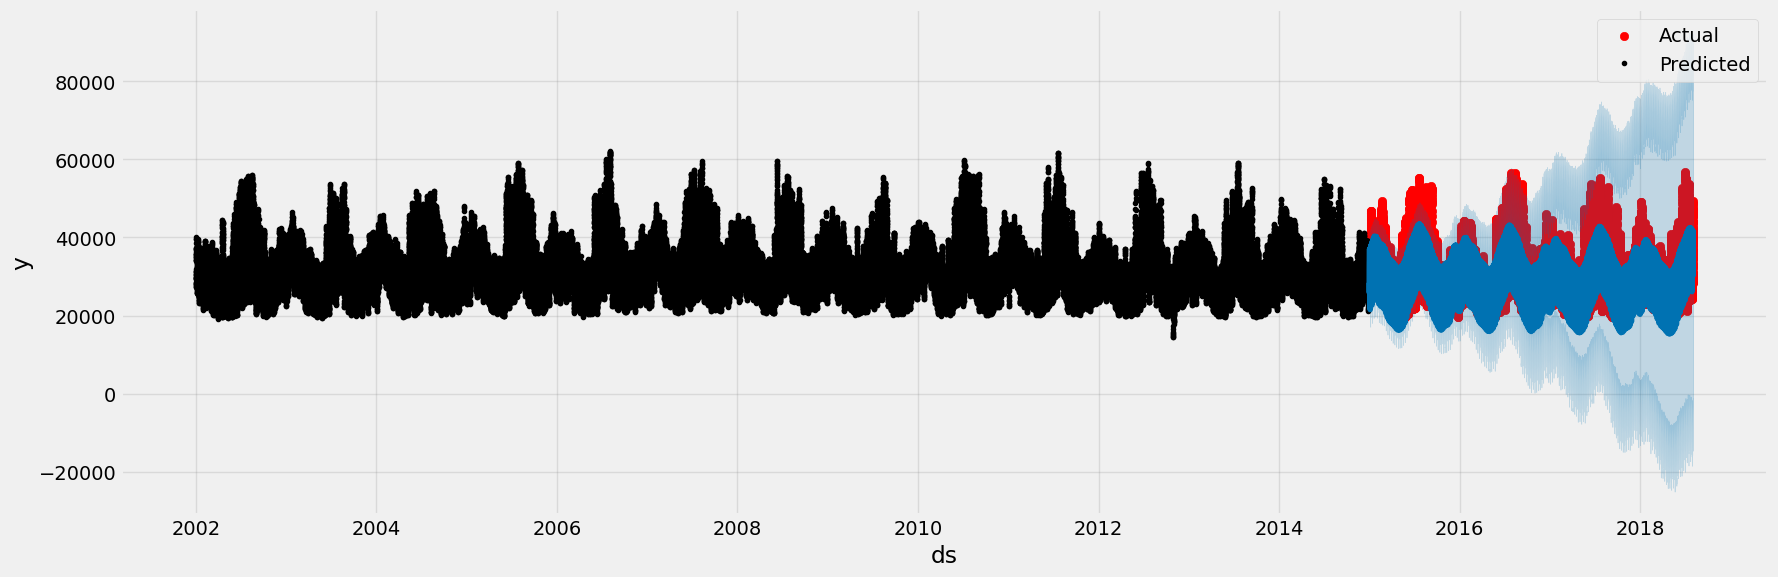

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(18)
ax.scatter(test.index, test['Energy'], color='r')
fig = model.plot(test_pred, ax=ax)
plt.legend(["Actual","Predicted"])

## Metrics for Prophet's performance on test set

In [ ]:
y_true=test['Energy']
y_pred=test_pred['yhat']
print("Mean absolute error is ",mean_absolute_error(y_true,y_pred))
print("Mean squared error is ",mean_squared_error(y_true,y_pred))
print("Mean absolute percentage error is ",mean_absolute_percentage_error(y_true,y_pred))
print("R square is ",r2_score(y_true,y_pred))

Mean absolute error is  3104.669376503115
Mean squared error is  16984051.40389661
Mean absolute percentage error is  9.620061802158176
R square is  0.5917286822204624


# Prophet Model with Holidays added

In [ ]:
cal = calendar()
train_holidays = cal.holidays(start=train.index.min(), end=train.index.max())
test_holidays = cal.holidays(start=test.index.min(), end=test.index.max())

In [ ]:
# Create a dataframe with holiday, ds columns
data['date'] = data.index.date
data['is_holiday'] = data.date.isin([d.date() for d in cal.holidays()])
holiday_df = data.loc[data['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['Energy','date','is_holiday'], axis=1)
holiday_df.head()

,ds,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
0,2002-01-01 01:00:00,1,1,1,1,2002,1,1,1,USFederalHoliday
1,2002-01-01 02:00:00,2,1,1,1,2002,1,1,1,USFederalHoliday
2,2002-01-01 03:00:00,3,1,1,1,2002,1,1,1,USFederalHoliday
3,2002-01-01 04:00:00,4,1,1,1,2002,1,1,1,USFederalHoliday
4,2002-01-01 05:00:00,5,1,1,1,2002,1,1,1,USFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train.reset_index().rename(columns={'Datetime':'ds','Energy':'y'}))

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [ ]:
# Predict on training set with model
test_pred_hol = model_with_holidays.predict(df=test.reset_index().rename(columns={'Datetime':'ds'}))

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9

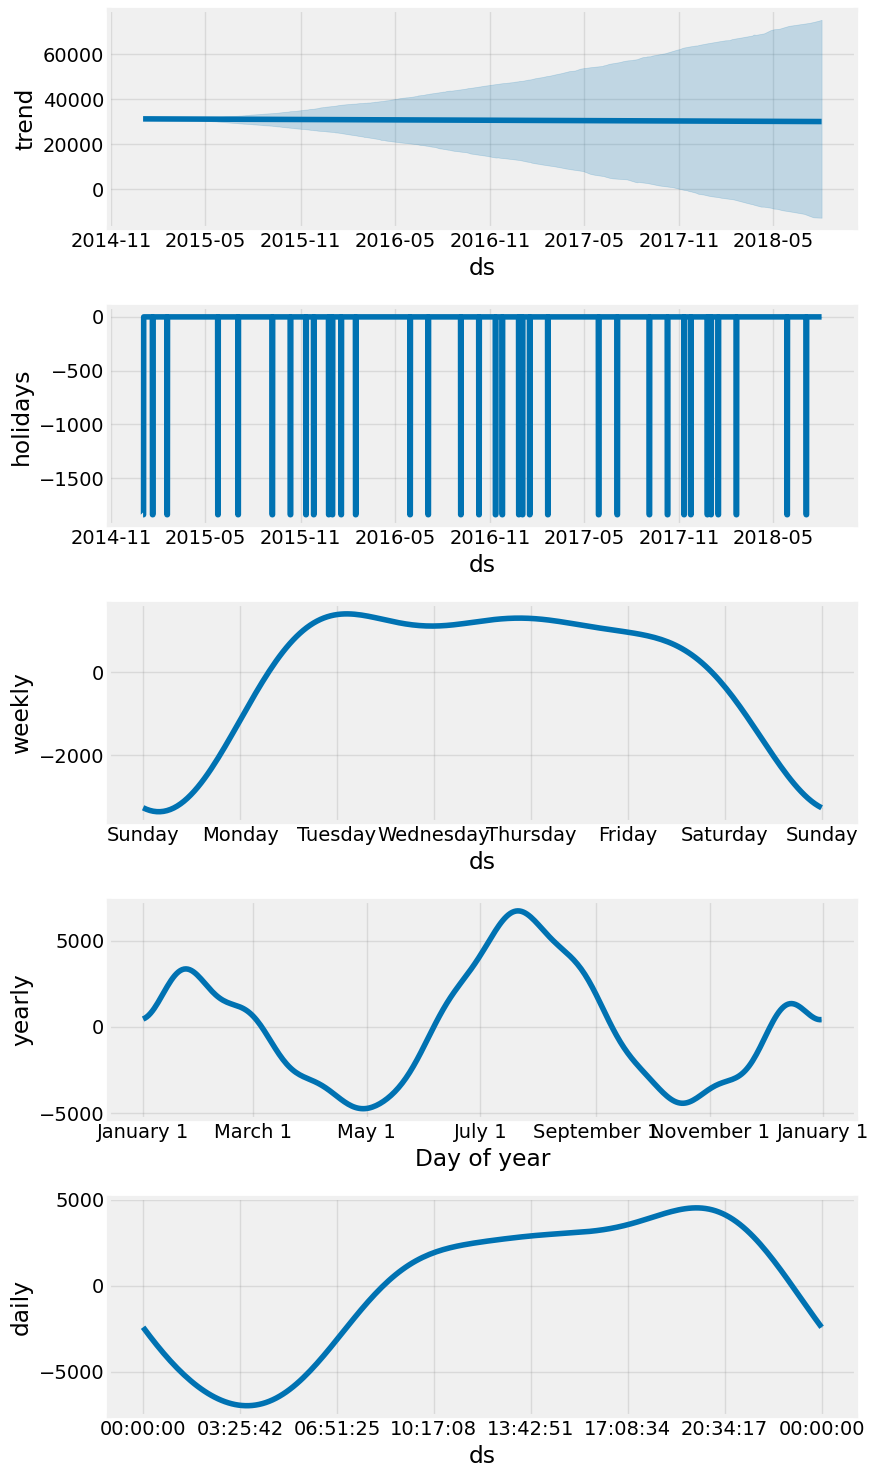

In [ ]:
fig2 = model_with_holidays.plot_components(test_pred_hol)

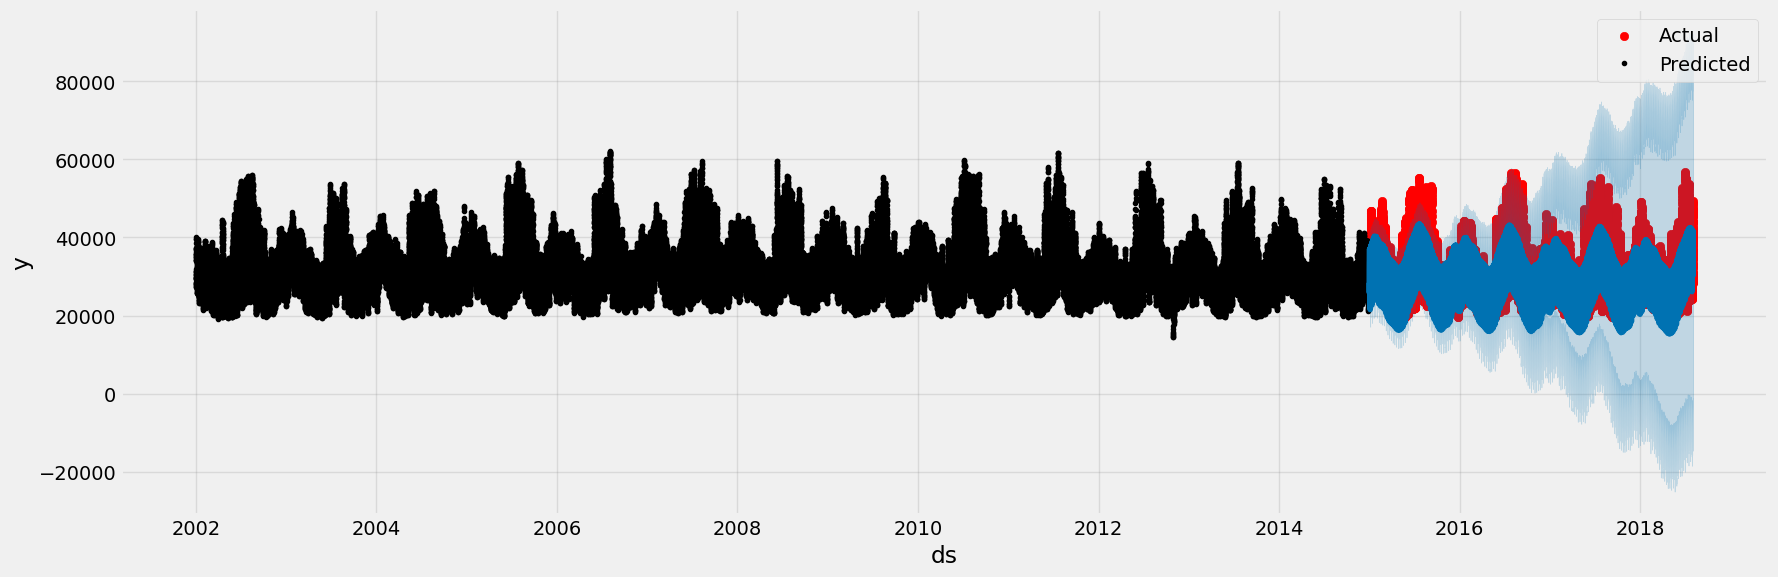

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(18)
ax.scatter(test.index, test['Energy'], color='r')
fig = model.plot(test_pred, ax=ax)
plt.legend(["Actual","Predicted"])
plt.show()

## Metrics for Prophet's performance on test set

In [ ]:
y_true=test['Energy']
y_pred=test_pred_hol['yhat']
print("Mean absolute error is ",mean_absolute_error(y_true,y_pred))
print("Mean squared error is ",mean_squared_error(y_true,y_pred))
print("Mean absolute percentage error is ",mean_absolute_percentage_error(y_true,y_pred))
print("R square is ",r2_score(y_true,y_pred))

Mean absolute error is  3103.2851065014124
Mean squared error is  16971963.43290885
Mean absolute percentage error is  9.616296987511708
R square is  0.5920192590520492


# Machine Learning Approach (XGBoost Regressor)

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=False)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

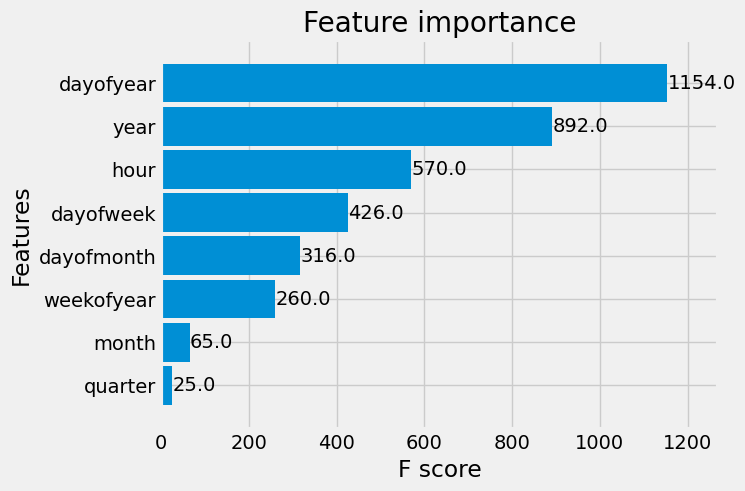

In [ ]:
_ = plot_importance(model, height=0.9)

In [ ]:
test['Prediction'] = model.predict(X_test)
train["Prediction"]= model.predict(X_train)
new_data = pd.concat([test, train], sort=False)

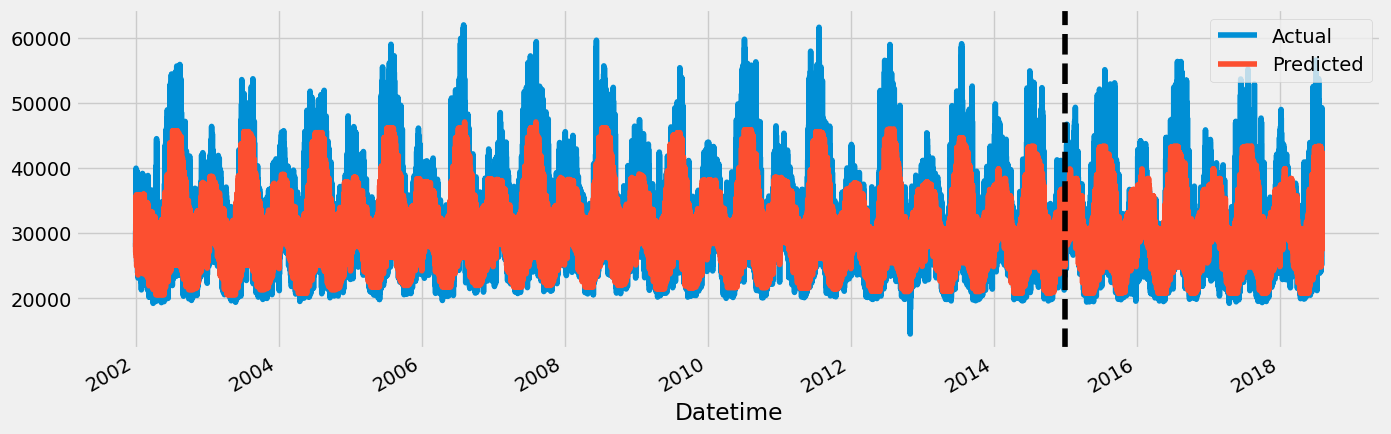

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
new_data["Energy"].plot(ax=ax, label="Actual")
new_data["Prediction"].plot(ax=ax, label="Predicted")

ax.axvline('01-01-2015',color="black",ls="--")
ax.legend(loc="best")
plt.show()

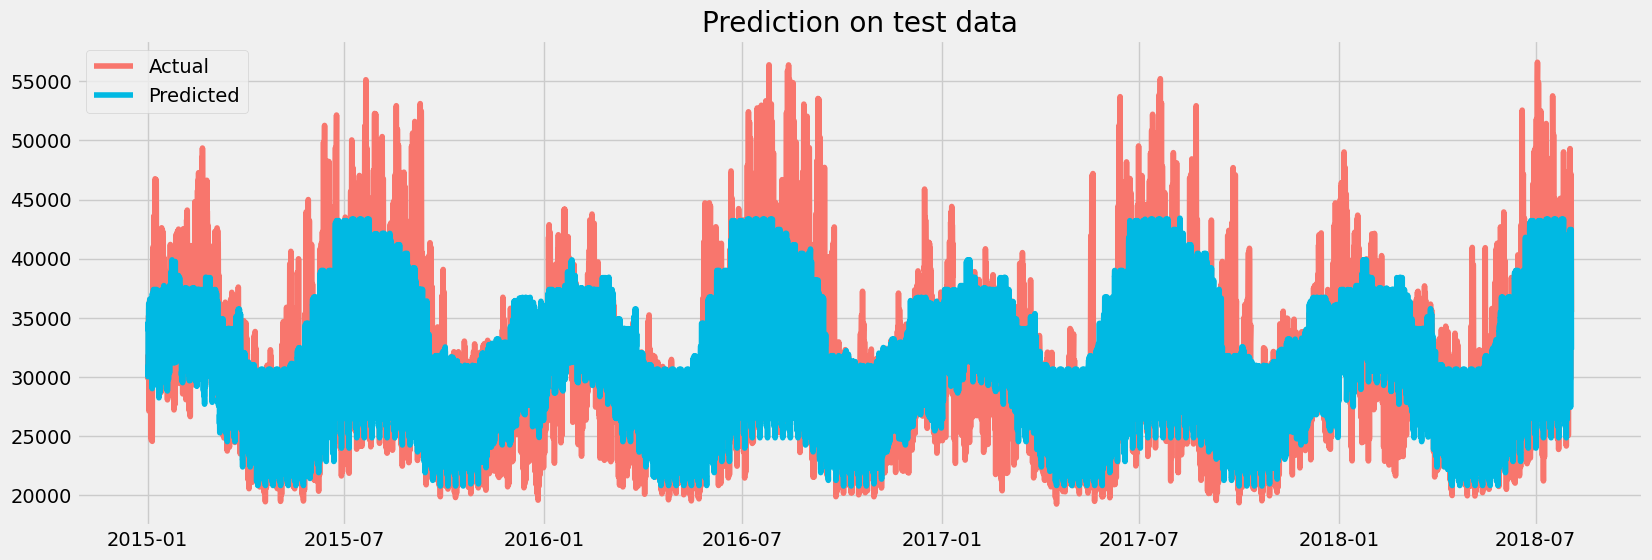

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(test["Energy"],label="Actual", color="#F8766D")
plt.plot(test["Prediction"],label="Predicted",color="#00B9E3")
plt.title("Prediction on test data")
plt.legend(loc="best")
plt.show()

In [ ]:
new_data.head()

,Energy,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Prediction
Datetime,,,,,,,,,,,
2015-01-01 01:00:00,31647.0,2015-01-01 01:00:00,1,3,1,1,2015,1,1,1,30334.513672
2015-01-01 02:00:00,30755.0,2015-01-01 02:00:00,2,3,1,1,2015,1,1,1,30388.841797
2015-01-01 03:00:00,30189.0,2015-01-01 03:00:00,3,3,1,1,2015,1,1,1,30523.792969
2015-01-01 04:00:00,29890.0,2015-01-01 04:00:00,4,3,1,1,2015,1,1,1,30523.792969
2015-01-01 05:00:00,30075.0,2015-01-01 05:00:00,5,3,1,1,2015,1,1,1,30523.792969


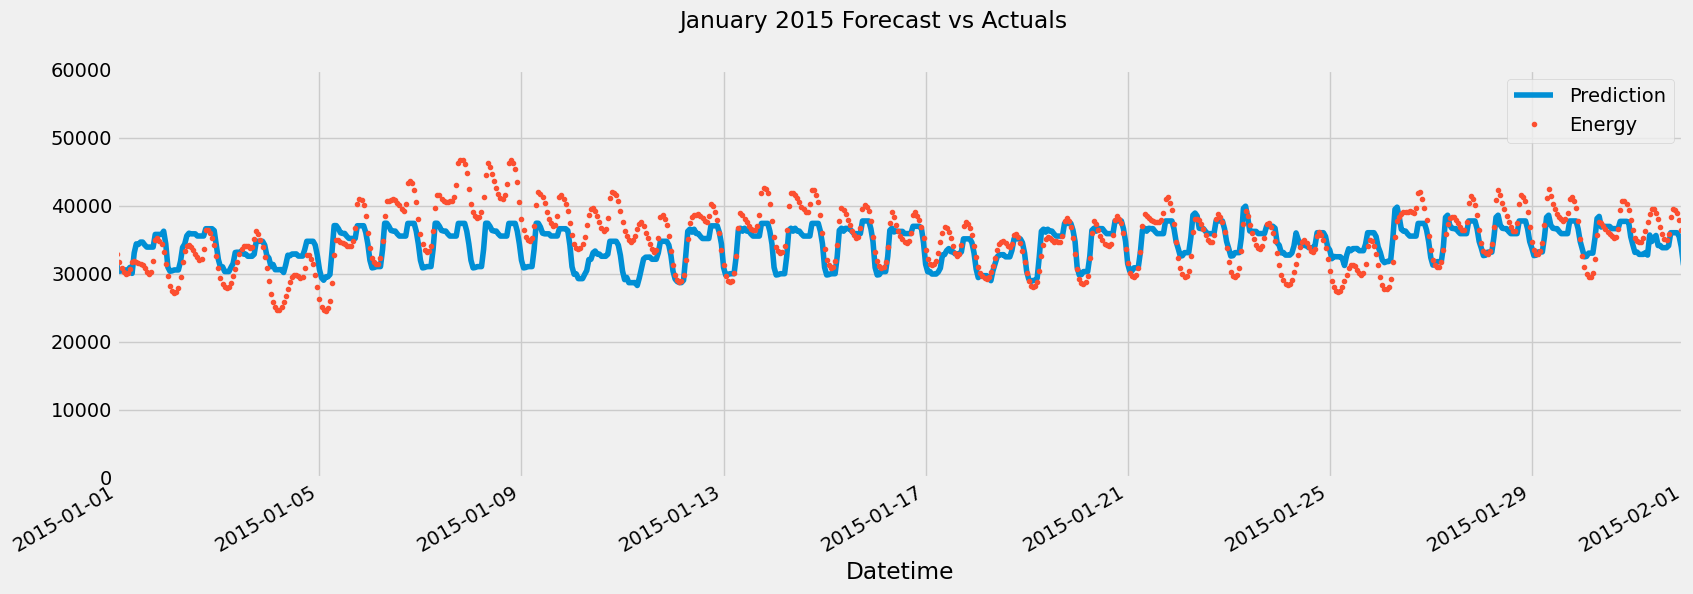

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(18)
_ = new_data[['Prediction','Energy']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

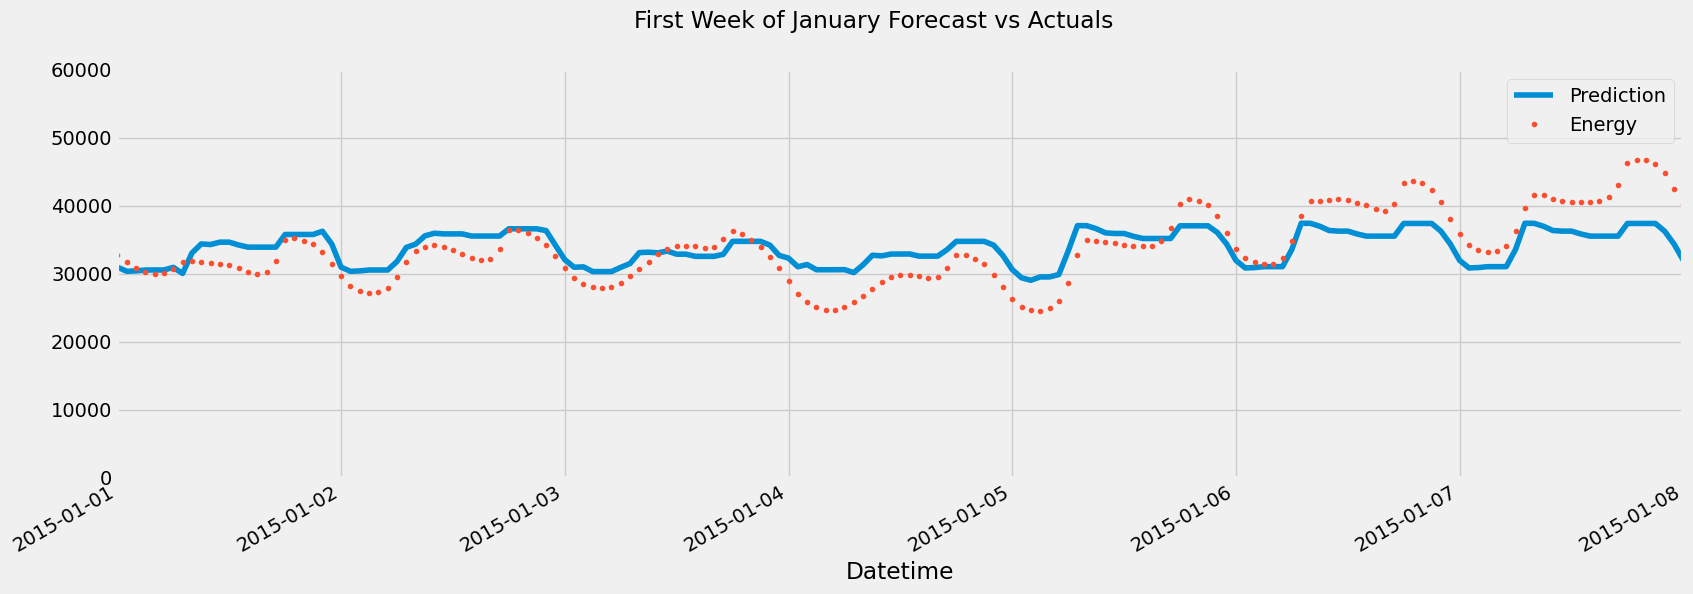

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(18)
_ = new_data[['Prediction','Energy']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

## Metrics for XGBoost Regressor's performance on test set

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [ ]:
y_true=test['Energy']
y_pred=test['Prediction']
print("Mean absolute error is ",mean_absolute_error(y_true,y_pred))
print("Mean squared error is ",mean_squared_error(y_true,y_pred))
print("Mean absolute percentage error is ",mean_absolute_percentage_error(y_true,y_pred))
print("R square is ",r2_score(y_true,y_pred))

Mean absolute error is  2757.2169004982866
Mean squared error is  13960913.30565261
Mean absolute percentage error is  8.510847348494002
R square is  0.6644004226578725


In [ ]:
test['error'] = test['Energy'] - test['Prediction']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']).mean()[['Energy','Prediction','error','abs_error']]

<ipython-input-51-a8eb8d0d6e6c>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_day = test.groupby(['year','month','dayofmonth']).mean()[['Energy','Prediction','error','abs_error']]


In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Energy    Prediction        error    abs_error
year month dayofmonth                                                      
2016 7     4           28399.958333  36429.839844 -8029.882894  8029.882894
2017 2     24          26445.083333  34425.839844 -7980.756429  7980.756429
           25          24344.458333  31702.664062 -7358.206299  7358.206299
     9     4           26552.416667  33609.351562 -7056.935954  7056.935954
     2     20          27070.583333  33860.238281 -6789.655355  6789.655355
     9     1           27280.500000  33966.476562 -6685.977132  6685.977132
     2     19          24555.500000  31178.529297 -6623.027913  6623.027913
2018 2     21          27572.500000  34057.515625 -6485.015869  6485.015869
2017 3     1           27574.125000  34057.515625 -6483.390869  6483.390869
     2     23          27663.416667  34141.667969 -6478.251872  6478.251872

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Energy    Prediction         error     abs_error
year month dayofmonth                                                        
2016 8     13          45185.833333  31390.197266  13795.634766  13795.634766
           14          44427.333333  31185.373047  13241.961751  13241.961751
     9     10          40996.166667  27985.250000  13010.917562  13010.917562
           9           43836.958333  32078.492188  11758.466064  11758.466064
     8     12          45724.708333  34440.406250  11284.303223  11284.303223
2018 1     6           43565.750000  32572.080078  10993.670003  10993.670003
2015 2     20          44694.041667  33874.222656  10819.821045  10819.821045
2017 5     19          38032.583333  27777.609375  10254.974935  10254.974935
2015 2     16          43949.500000  33860.238281  10089.261312  10089.261312
     9     9           42266.875000  32276.361328   9990.514160   9990.514160

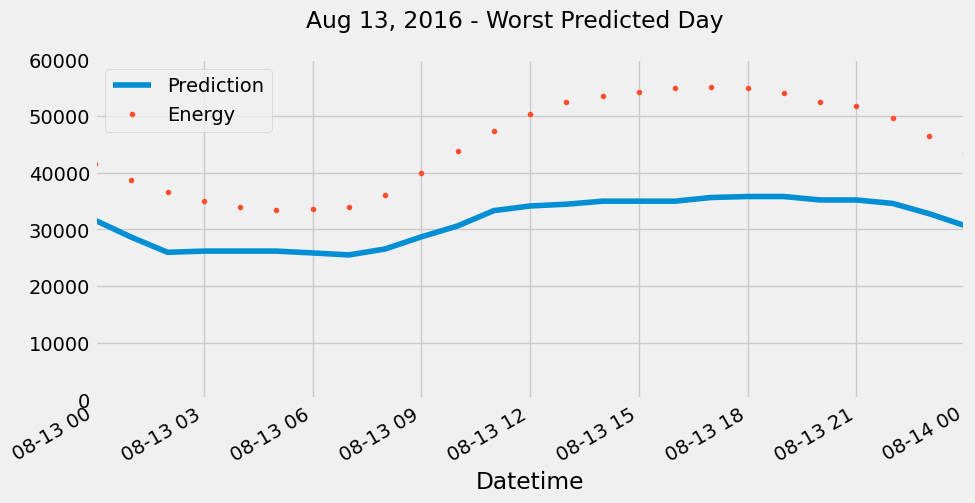

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = new_data[['Prediction','Energy']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Energy    Prediction       error   abs_error
year month dayofmonth                                                    
2018 5     13          24001.500000  24218.673828 -217.174967  338.625000
2016 4     4           28944.125000  28569.859375  374.264323  429.709147
     9     28          27910.833333  28260.044922 -349.209961  479.797038
2015 10    3           25534.875000  25807.494141 -272.620850  485.690348
     9     22          28185.875000  28314.943359 -129.067383  496.139974
     4     20          27369.000000  27608.919922 -239.918376  503.891357
2018 5     17          28035.208333  28513.267578 -478.060872  515.793783
2016 10    2           24659.083333  25016.306641 -357.224284  515.855794
2015 9     21          27988.041667  28057.208984  -69.165365  517.167806
2017 5     13          24752.333333  24626.263672  126.069092  531.713135

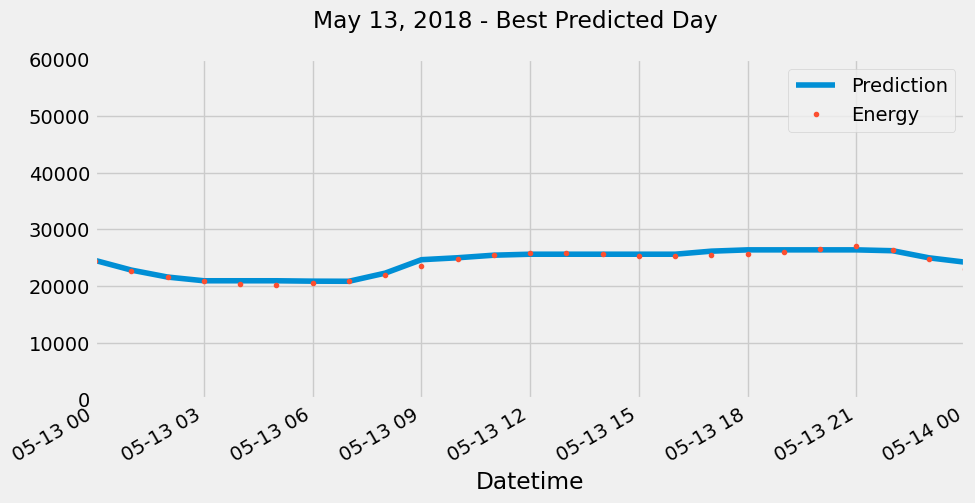

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = new_data[['Prediction','Energy']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-13-2018', upper='05-14-2018')
plot = plt.suptitle('May 13, 2018 - Best Predicted Day')